In [1]:
# ---------------------------------------------------------------------------- #
#                              Import the modules                              #
# ---------------------------------------------------------------------------- #
import pandas as pd
from pyomo.environ import *

# ---------------------------------------------------------------------------- #
#                             Initialize the MODEL                             #
# ---------------------------------------------------------------------------- #
model = ConcreteModel()

machines = [1, 2, 3, 4, 5]
products = [1, 2, 3]
products_dict = {1:"A",2:"B",3:"C"}


# ---------------------------------------------------------------------------- #
#                                Define the SETS                               #
# ---------------------------------------------------------------------------- #
model.machines = RangeSet(1,5)
model.products = RangeSet(1,3)

# ---------------------------------------------------------------------------- #
#                             Define the VARIABLES                             #
# ---------------------------------------------------------------------------- #

model.X = Var(model.machines, model.products, within=NonNegativeIntegers)
model.Y = Var(model.machines, model.products, within=NonNegativeIntegers)
model.P = Var(within=Binary)
model.F1 = Var(within=Binary)
model.F2 = Var(within=Binary)
model.F3 = Var(within=Binary)
model.G = Var(within=Binary)
model.K = Var(within=Binary)
model.Q = Var(within=Binary)

model.L = Var(within=NonNegativeIntegers)

# ---------------------------------------------------------------------------- #
#                         Define the OBJECTIVE FUNCTION                        #
# ---------------------------------------------------------------------------- #
model.objective = Objective(expr=model.L, sense=minimize)

# ---------------------------------------------------------------------------- #
#                               Define the PARAMS                              #
# ---------------------------------------------------------------------------- #
times = pd.read_excel('Time Data.xlsx', index_col=0)

keys = list(times.to_dict().keys())
values = list(times.to_dict().values())

time_params = {(j+1,i):k for i in range(1,len(keys)+1) for j,k in enumerate(values[i-1].values())}

model.time_params = time_params

# ----------------------------------- Big M ---------------------------------- #
model.M = 1e6

# ---------------------------------------------------------------------------- #
#                            Define the CONSTRAINTS                            #
# ---------------------------------------------------------------------------- #

# -------------------- Linearazation of objective function ------------------- #
model.objective_linear = ConstraintList()
model.objective_linear.add(model.L >= model.Y[4, 1])
model.objective_linear.add(model.L >= model.Y[5, 2])
model.objective_linear.add(model.L >= model.Y[5, 3])

# ---------------------------------- X and Y --------------------------------- #
model.start_and_end_time_relation = ConstraintList()
for machine in machines:
    for product in products:
        model.start_and_end_time_relation.add(model.Y[machine, product] >= model.X[machine, product])
        model.start_and_end_time_relation.add(model.X[machine, product] + model.time_params[machine, product] == model.Y[machine, product])

# ----------- Each product must pass through machines sequentially ----------- #
model.sequentials = ConstraintList()
for j in products:
    for i in range(1,len(machines)):
        model.sequentials.add(model.Y[i, j] <= model.X[i+1, j])
model.sequentials.add(model.Y[4, 1] <= 60)
model.sequentials.add(model.Y[5, 2] <= model.Y[5, 3] + 15)


# --------------------- Machines can do one thing at once -------------------- #
model.interferences = ConstraintList()

# Machine 1
model.interferences.add(expr = model.X[1, 1] - model.Y[1, 2] >= 4 - model.M*model.P)
model.interferences.add(expr = model.X[1, 2] - model.Y[1, 1] >= 4 - model.M*(1 - model.P))

# Machine 2
model.interferences.add(expr = model.X[2, 2] - model.Y[2, 1] >= 10 - model.M*model.F1)
model.interferences.add(expr = model.X[2, 1] - model.Y[2, 2] >= 10 - model.M*(1 - model.F1))
model.interferences.add(expr = model.X[2, 3] - model.Y[2, 1] >= 10 - model.M*model.F2)
model.interferences.add(expr = model.X[2, 1] - model.Y[2, 3] >= 10 - model.M*(1 - model.F2))
model.interferences.add(expr = model.X[2, 2] - model.Y[2, 3] >= 10 - model.M*model.F3)
model.interferences.add(expr = model.X[2, 3] - model.Y[2, 2] >= 10 - model.M*(1 - model.F3))

# Machine 3
model.interferences.add(expr = model.X[3, 3] - model.Y[3, 1] >= 5 - model.M*model.G)
model.interferences.add(expr = model.X[3, 1] - model.Y[3, 3] >= 5 - model.M*(1 - model.G))

# Machine 4
model.interferences.add(expr = model.X[4, 1] - model.Y[4, 2] >= 20 - model.M*model.K)
model.interferences.add(expr = model.X[4, 2] - model.Y[4, 1] >= 20 - model.M*(1 - model.K))

# Machine 5
model.interferences.add(expr = model.X[5, 2] - model.Y[5, 3] >= -model.M*model.Q)
model.interferences.add(expr = model.X[5, 3] - model.Y[5, 2] >= -model.M*(1 - model.Q))

# ---------------------------------------------------------------------------- #
#                              Binary constraints                              #
# ---------------------------------------------------------------------------- #
model.binaries = ConstraintList()

model.binaries.add(expr = model.F2 + model.F3 - model.F1 >= 0)
model.binaries.add(expr = model.F2 + model.F3 - model.F1 <= 1)

# ---------------------------------------------------------------------------- #
#                                Solve the model                               #
# ---------------------------------------------------------------------------- #
solver = SolverFactory('cplex')
solver.solve(model)

print(f'objective function : {value(model.objective)}')

for x in model.machines:
    for y in model.products:
        print(f'value of {model.X[x,y]}={value(model.X[x,y])}')
        print(f'value of {model.Y[x,y]}={value(model.Y[x,y])}')

objective function : 96.0
value of X[1,1]=0.0
value of Y[1,1]=10.0
value of X[1,2]=14.0
value of Y[1,2]=22.0
value of X[1,3]=0.0
value of Y[1,3]=0.0
value of X[2,1]=10.0
value of Y[2,1]=16.0
value of X[2,2]=26.0
value of Y[2,2]=35.0
value of X[2,3]=45.0
value of Y[2,3]=54.0
value of X[3,1]=16.0
value of Y[3,1]=28.0
value of X[3,2]=70.0
value of Y[3,2]=70.0
value of X[3,3]=61.0
value of Y[3,3]=75.0
value of X[4,1]=28.0
value of Y[4,1]=50.0
value of X[4,2]=70.0
value of Y[4,2]=89.0
value of X[4,3]=75.0
value of Y[4,3]=75.0
value of X[5,1]=50.0
value of Y[5,1]=50.0
value of X[5,2]=89.0
value of Y[5,2]=96.0
value of X[5,3]=75.0
value of Y[5,3]=81.0


NameError: name 'np' is not defined

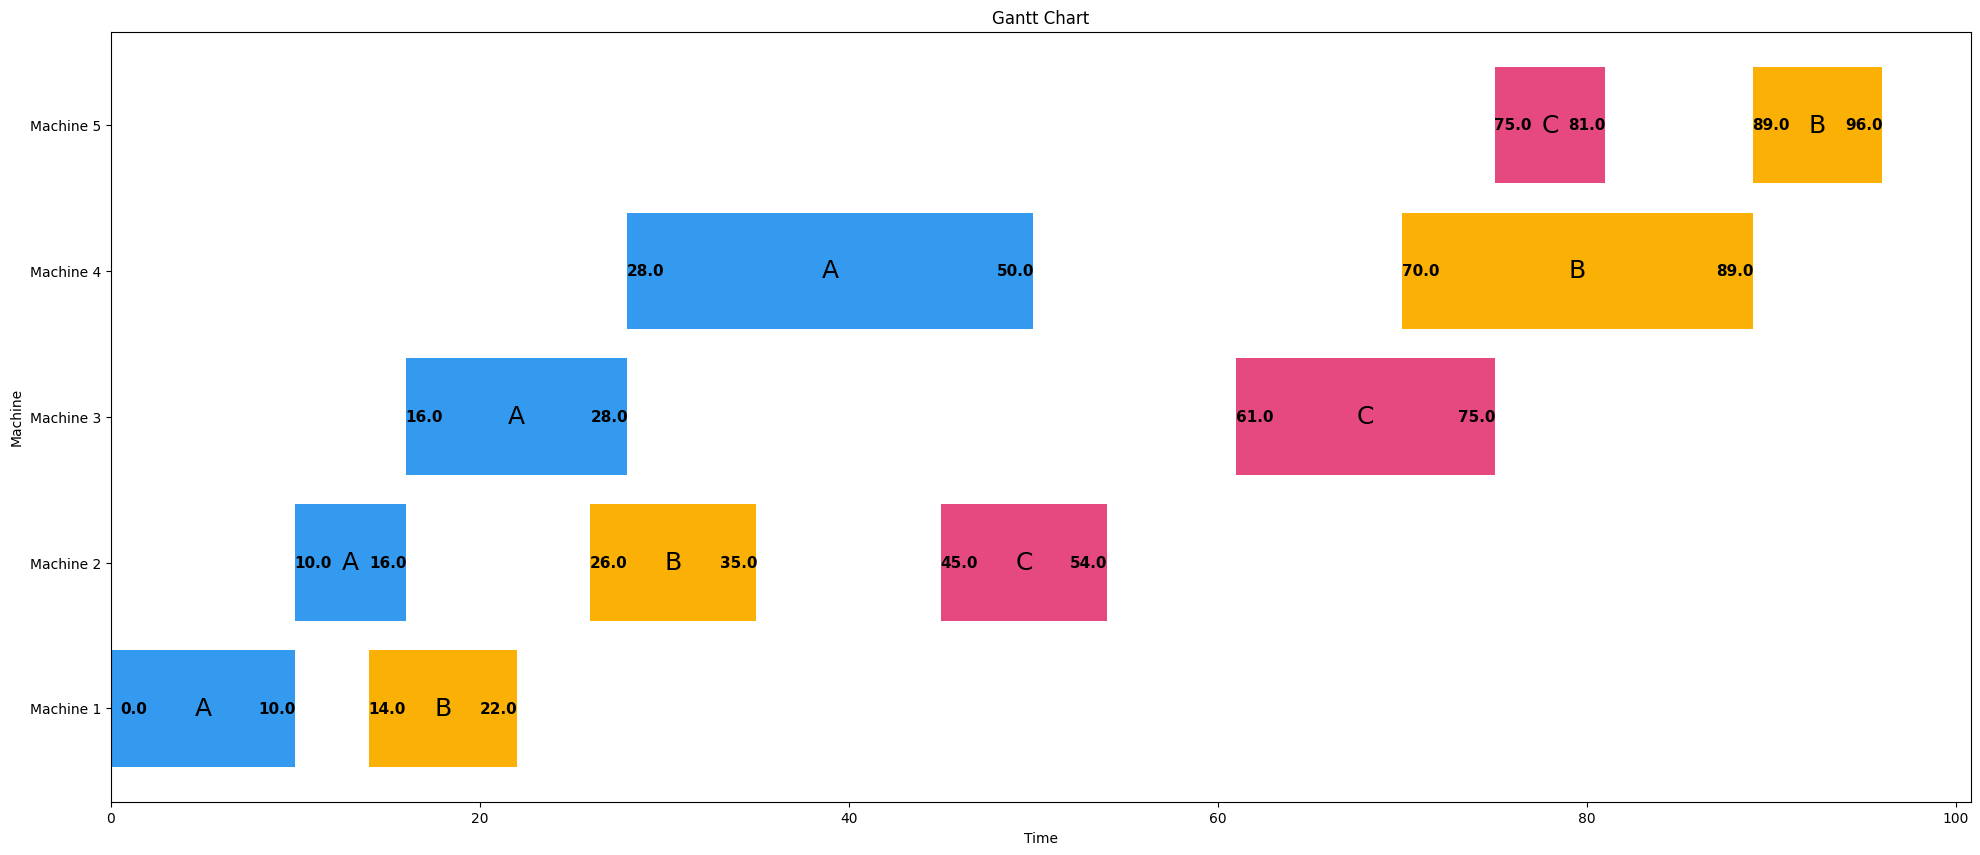

In [2]:
import matplotlib.pyplot as plt
import matplotlib

fig, ax = plt.subplots(figsize=(24, 10))

products_color = {1: "#339af0", 2:"#fab005", 3:"#e64980"}

for x in model.machines:
    for y in model.products:
        start = value(model.X[x,y])
        end = value(model.Y[x,y])
        ax.barh(f'Machine {x}', width = end - start, left = start, color=products_color[y])
        if (start != end):
            ax.text(start + (end - start) / 2, x-1,f'{products_dict[y]}', va='center', ha='center',fontsize=18)
            ax.text(start+2, x-1, f"{start}", ha='right', va='center', fontweight = 700, fontsize=11)
            ax.text(end-2, x-1, f"{end}", ha='left', va='center', fontweight = 700, fontsize=11)

ax.set_xlabel('Time')
ax.set_ylabel('Machine')
ax.set_title('Gantt Chart')

ax.xaxis.set_ticks(np.arange(1, 100,1))

matplotlib.rcParams['font.family'] = ["Comic Sans MS"]

plt.show()
